<a href="https://colab.research.google.com/github/blortle-dev/data-science-lasa/blob/main/Unit%205/ColiDicaU5Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unit 5 Project - Modelling the Finishing Position of Drivers Over Time

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import xarray as xr
import pymc as pm
from scipy.interpolate import PchipInterpolator

In [ ]:
url = "https://raw.githubusercontent.com/blortle-dev/data-science-lasa/refs/heads/main/resources/results.csv"
data = pd.read_csv(url)

In [ ]:
data = data[data["constructorId"] == 3]
data = data[data["raceId"] > 900]
data = data[data["position"] != "\\N"]

In [ ]:
data.head()

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
22155,22158,901,13,3,19,13,7,7,7,6.0,56,+1:25.076,6111050,44,6,1:44.897,190.232,1
22156,22159,901,822,3,77,18,8,8,8,4.0,56,+1:25.537,6111511,31,9,1:45.475,189.189,1
22177,22180,902,13,3,19,7,7,7,7,6.0,57,+31.265,6014008,40,5,1:39.272,196.260,1
22178,22181,902,822,3,77,3,8,8,8,4.0,57,+31.876,6014619,50,13,1:39.762,195.296,1
22199,22202,903,822,3,77,7,7,7,7,6.0,54,+55.697,5664035,52,11,1:42.660,191.151,1


Then, I encountered another issue that really just confused me. The Y axis of my data was all over the place, not in any numerical order. Take a look:

<Axes: xlabel='raceId', ylabel='position'>

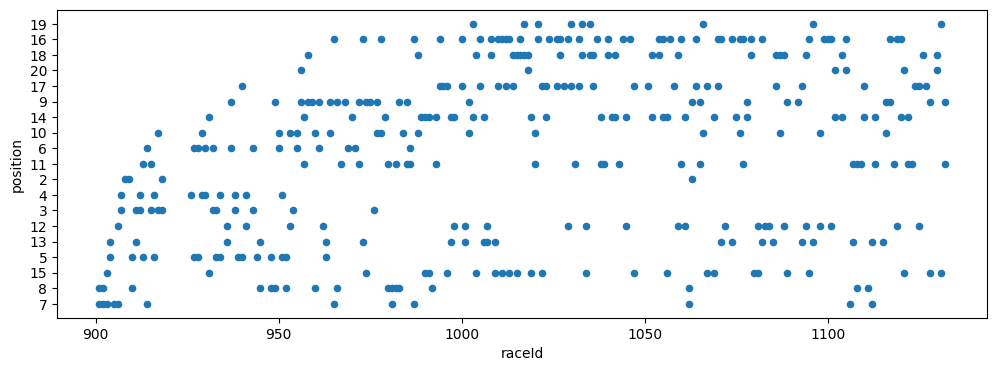

In [ ]:
# Scatter plot of finishing positions in each of the past ~300 races
data.plot(x="raceId", y="position", figsize=(12, 4), kind="scatter")

I then used the next block of code to look at my data types, and realized that the `position` column was still type `object`.
(this is because it had `string` entries originally, so it kept it's datatype even after removing the strings)

In [ ]:
print(data.dtypes)

resultId             int64
raceId               int64
driverId             int64
constructorId        int64
number              object
grid                 int64
position            object
positionText        object
positionOrder        int64
points             float64
laps                 int64
time                object
milliseconds        object
fastestLap          object
rank                object
fastestLapTime      object
fastestLapSpeed     object
statusId             int64
dtype: object


Luckily, it's a simple line of code to convert the `position` column to int64.

In [ ]:
data['position'] = pd.to_numeric(data['position'])

In [ ]:
print(data.dtypes)

resultId             int64
raceId               int64
driverId             int64
constructorId        int64
number              object
grid                 int64
position             int64
positionText        object
positionOrder        int64
points             float64
laps                 int64
time                object
milliseconds        object
fastestLap          object
rank                object
fastestLapTime      object
fastestLapSpeed     object
statusId             int64
dtype: object


Now that that's fixed, let's plot out the driver's race results since the 2014 Australian Grand Prix:

<Axes: xlabel='raceId', ylabel='position'>

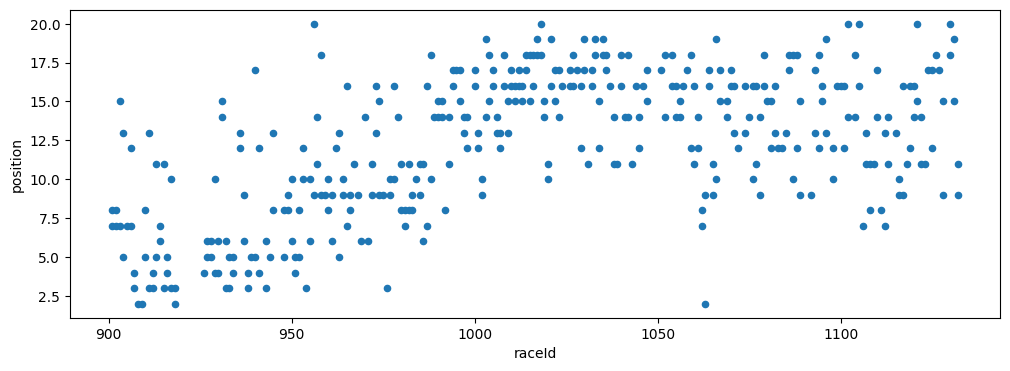

In [ ]:
# Scatter plot of finishing positions in each of the past ~300 races
data.plot(x="raceId", y="position", figsize=(12, 4), kind="scatter")

This graph looks.. strange to say the least. It doesn't have a linear or logarithmic trend. When I tried to use this to build my model, none of the options looked anywhere close to a good fit of my data. Here's where the complicated part starts. After some discussions with my classmates however, we determined that it looked awfully quartic.

Why would it be quartic, though? The graph above shows raceId (a function of time) and how that relates to position. However, the position has a lot of contributing factors, such as:
- the car's performance
- wear on the car's components such as the engine
- the track and the driver's experience on it
- the driver's performance
- temperature
- all of the above factors 19 more times
(each raceId has two associated position values, one per driver)
So, the team's performance isn't necessarily a quartic trend, rather that the factors mentioned earlier ended in what ends up following a quartic function very nicely.

Just to test, I tried my model with the square root model provided in the Unit 5 Notes AK, and got this output:

In [ ]:
with pm.Model() as model_sqrtf1:

    #priors for our mean line
    α = pm.Normal("α", sigma=10)
    β = pm.Normal("β", sigma=10)

    #mean line
    μ = pm.Deterministic("μ", α + β * pm.math.sqrt(data.raceId))

    #prior for standard deviation
    σ = pm.HalfNormal("σ", sigma = 10)

    #normal likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=data.position)

    idata_sqrtf1 = pm.sample()

Output()

Output()

Text(0, 0.5, 'position')

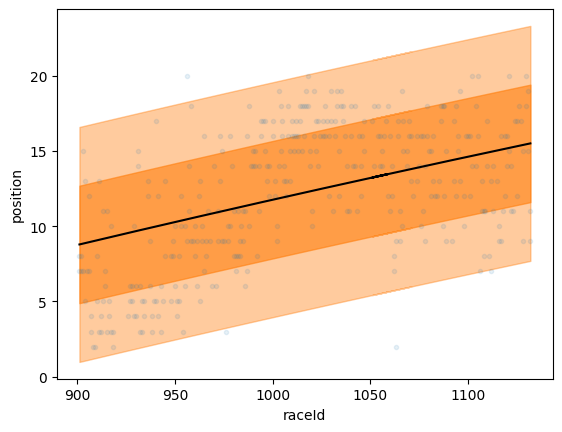

In [ ]:
#plots the posterior

_, ax = plt.subplots()

ax.plot(data.raceId, data.position, "C0.", alpha=0.1)

posterior_sqrtba = az.extract(idata_sqrtf1)

μ_m = posterior_sqrtba["μ"].mean("sample").values
σ_m = posterior_sqrtba["σ"].mean("sample").values

ax.plot(data.raceId, μ_m, c="k")
ax.fill_between(data.raceId, μ_m + 1 * σ_m, μ_m - 1 * σ_m, alpha=0.6, color="C1")
ax.fill_between(data.raceId, μ_m + 2 * σ_m, μ_m - 2 * σ_m, alpha=0.4, color="C1")

ax.set_xlabel("raceId")
ax.set_ylabel("position")

This looks bad. How's the posterior predictive look?

Output()

<Axes: xlabel='y_pred'>

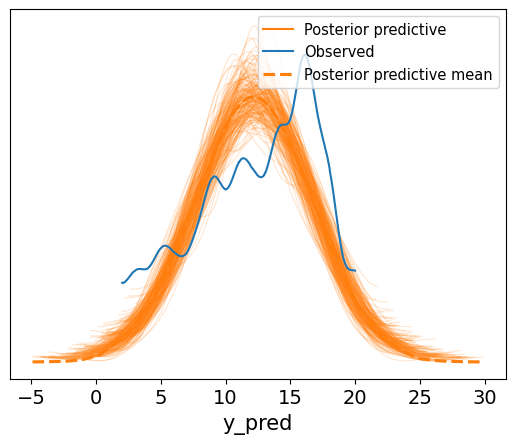

In [ ]:
#creates our posterior predictive distribution
pm.sample_posterior_predictive(
    idata_sqrtf1, model = model_sqrtf1, extend_inferencedata=True
    )

# posterior predictive check
az.plot_ppc(idata_sqrtf1, num_pp_samples=200, colors=["C1", "C0", "C1"])

Horrible, as expected.

Getting quartic functions to work with my model is quite difficult in pymc. So, I looked over to the Unit 7 Notes, where importantly, there is a simple way to create a quartic model for my data using the bambi module. We're gonna have to install and import bambi before going further.

In [ ]:
!pip install bambi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.9/107.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 3.5 MB/s eta 0:00:00


In [ ]:
import bambi as bmb

Just for fun, let's test what a cubic function would look like for my model:

In [ ]:
# Stolen from the Unit 7 Notes AK

model_poly_1 = bmb.Model("position ~ poly(raceId, degree=3)", data, family="negativebinomial")

idata_poly_1 = model_poly_1.fit()

Sampling chain 1, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:09

/usr/local/lib/python3.10/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


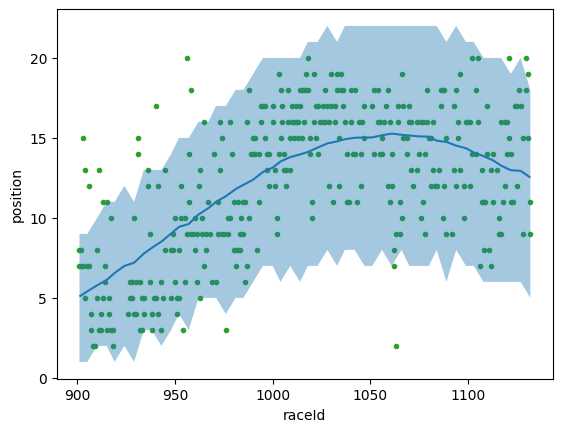

In [ ]:
bmb.interpret.plot_predictions(model_poly_1, idata_poly_1, "raceId", pps=True)
plt.plot(data.raceId, data.position, "C2.", zorder=-3)

It's not a bad fit, and easily better than my first attempt. But, it has a few problems. It doesn't follow the trend very well at the higher raceId values, and doesn't match well towards the center. Let's try a quintic model, now.

Output()

Output()

/usr/local/lib/python3.10/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


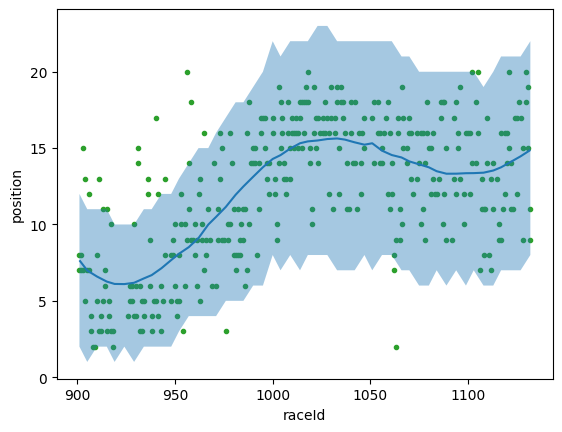

In [17]:
model_poly_2 = bmb.Model("position ~ poly(raceId, degree=5)", data, family="negativebinomial")

idata_poly_2 = model_poly_2.fit()

bmb.interpret.plot_predictions(model_poly_2, idata_poly_2, "raceId", pps=True)
plt.plot(data.raceId, data.position, "C2.", zorder=-3)

It's a great fit! However, towards the end, it seems to overfit a bit and goes off to the side. Still, I'd consider this a very solid option for this model. If you want a ton of overfitting, here's a 75th degree polynomial:

Output()

Output()

/usr/local/lib/python3.10/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


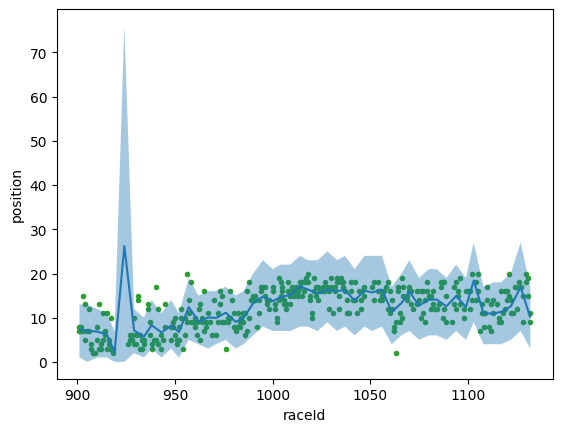

In [18]:
model_poly_3 = bmb.Model("position ~ poly(raceId, degree=75)", data, family="negativebinomial")

idata_poly_3 = model_poly_3.fit()

bmb.interpret.plot_predictions(model_poly_3, idata_poly_3, "raceId", pps=True)
plt.plot(data.raceId, data.position, "C2.", zorder=-3)

Alright, now let's use our quartic model.

Here's the code to make our model, from the Unit 7 Notes AK:

In [ ]:
# Stolen from the Unit 7 Notes AK

model_poly_final = bmb.Model("position ~ poly(raceId, degree=4)", data, family="negativebinomial")
#############################  Y AXIS ## X AXIS - 4th degree polynomial ##########################

# We can get our inference data using model.fit()
idata_poly_final = model_poly_final.fit()

Output()

Output()

This looks very different from the code we've used in previous units to generate our models, since bambi simplifies this process to two lines of code. The downside? I can't generate the same posterior predictive checks as the ones used in previous projects with pymc. Mine will look a little different. Here's the graph:

/usr/local/lib/python3.10/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


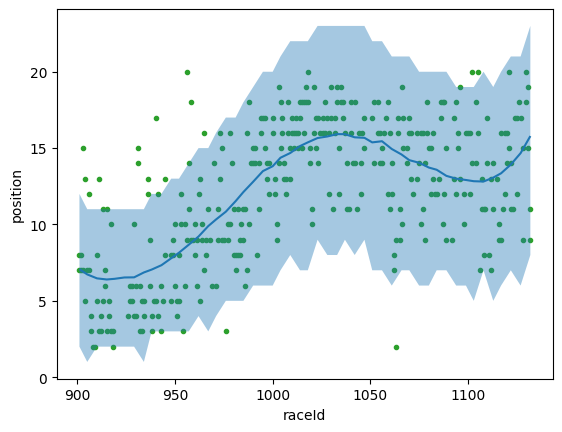

In [ ]:
# (also) stolen from Unit 7 Notes AK

bmb.interpret.plot_predictions(model_poly_final, idata_poly_final, "raceId", pps=True)
plt.plot(data.raceId, data.position, "C2.", zorder=-3)

Looking at this graph, we see the quartic function does a pretty good job at following our observed data. The only part where it has issues is the randomness between 900 and ~960, but other than that our model is a great fit.

# Failed Attempts

A collection of code that didn't work. Just to show what I tried, and won't run properly anymore.

<Axes: xlabel='y_pred'>

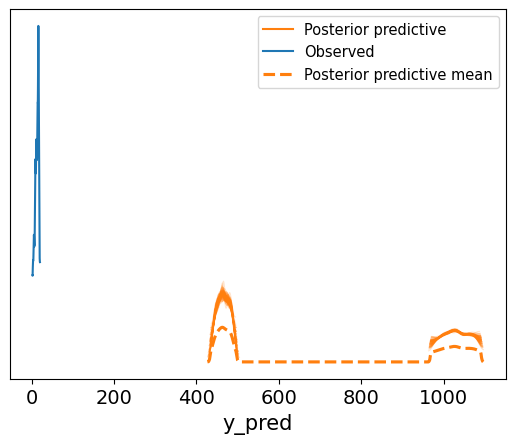

In [ ]:
# reminder to not set pymc's target_accept to values above 1 (I set it to 20 by accident)
# thought it looked funny so I kept it

az.plot_ppc(idata_poly_1, num_pp_samples=200, colors=["C1", "C0", "C1"])